In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly
import re

In [2]:
def clean(df, topk=False):
    df = df[df['State'] == 'finished']

    if topk:
        patterns = ['effective_l0$', 'frac_recovered$', 'mse_loss$', 'loss_original$', 'loss_reconstructed']
    else:
        patterns = ['l0$', 'frac_recovered$', 'mse_loss$', 'loss_original$', 'loss_reconstructed']
    filtered_columns = df.columns[df.columns.str.contains('|'.join(patterns))]
    df = df[filtered_columns]
    df.columns = [col.split('/')[-1] for col in df.columns]
    df = df.dropna(axis=1, how='any')
    
    if topk:
        l0 = df["effective_l0"].to_numpy().flatten()
    else:
        l0 = df["l0"].to_numpy().flatten()
    mse_loss = df["mse_loss"].to_numpy().flatten()
    frac_recovered = df["frac_recovered"].to_numpy().flatten()
    loss_original = df["loss_original"].to_numpy().flatten()
    loss_reconstructed = df["loss_reconstructed"].to_numpy().flatten()
    delta_ce = loss_reconstructed - loss_original

    data = np.array([l0, mse_loss, frac_recovered, delta_ce]).T
    df = pd.DataFrame(data, columns=['l0', 'mse_loss', 'frac_recovered', 'delta_ce'])
    df = df.sort_values(by='l0')
    return df

In [3]:
def clean_switch(df):
    df = df[df['State'] == 'finished']

    patterns = ['experts$', 'effective_l0$', 'mse_loss$', 'frac_recovered$', 'loss_original$', 'loss_reconstructed$', 'frac_recovered$']
    filtered_columns = df.columns[df.columns.str.contains('|'.join(patterns))]
    df = df[filtered_columns]
    df.columns = [re.split(r'[./]', col)[-1] for col in df.columns]
    
    l0 = df["effective_l0"].to_numpy().flatten()
    mse_loss = df["mse_loss"].to_numpy().flatten()
    experts = df["experts"].to_numpy().flatten()
    loss_original = df["loss_original"].to_numpy().flatten()
    loss_reconstructed = df["loss_reconstructed"].to_numpy().flatten()
    frac_recovered = df["frac_recovered"].to_numpy().flatten()
    delta_ce = loss_reconstructed - loss_original

    data = np.array([experts, l0, mse_loss, frac_recovered, delta_ce]).T
    df = pd.DataFrame(data, columns=['experts', 'l0', 'mse_loss', 'frac_recovered', 'delta_ce'])
    df = df.sort_values(by='l0')
    return df

In [4]:
def clean_interim(df):
    patterns = ['experts$', 'effective_l0$', 'l2_loss$']
    filtered_columns = df.columns[df.columns.str.contains('|'.join(patterns))]
    df = df[filtered_columns]
    df.columns = [re.split(r'[./]', col)[-1] for col in df.columns]
    
    l0 = df["effective_l0"].to_numpy().flatten()
    mse_loss = df["l2_loss"].to_numpy().flatten()
    experts = df["experts"].to_numpy().flatten()

    data = np.array([experts, l0, mse_loss]).T
    df = pd.DataFrame(data, columns=['experts', 'l0', 'mse_loss'])
    df = df.sort_values(by='l0')
    return df

In [5]:
df_relu = pd.read_csv("primary-relu.csv")
df_relu = clean(df_relu)

df_gated = pd.read_csv("primary-gated.csv")
df_gated = clean(df_gated)

df_topk = pd.read_csv("primary-topk.csv")
df_topk = clean(df_topk, topk=True)

In [6]:
df_relu.to_csv("primary-relu-clean.csv")
df_gated.to_csv("primary-gated-clean.csv")
df_topk.to_csv("primary-topk-clean.csv")

In [7]:
df_relu = pd.read_csv("primary-relu-clean.csv")
df_gated = pd.read_csv("primary-gated-clean.csv")
df_topk = pd.read_csv("primary-topk-clean.csv")

In [8]:
df_switch_flop = pd.read_csv('primary-switch-flop.csv')
df_switch_flop = clean_switch(df_switch_flop)

In [10]:
df_switch_flop2 = df_switch_flop[df_switch_flop['experts'] == 2]
df_switch_flop4 = df_switch_flop[df_switch_flop['experts'] == 4]
#df_switch_flop8 = df_switch_flop[df_switch_flop['experts'] == 8]

## Plotting

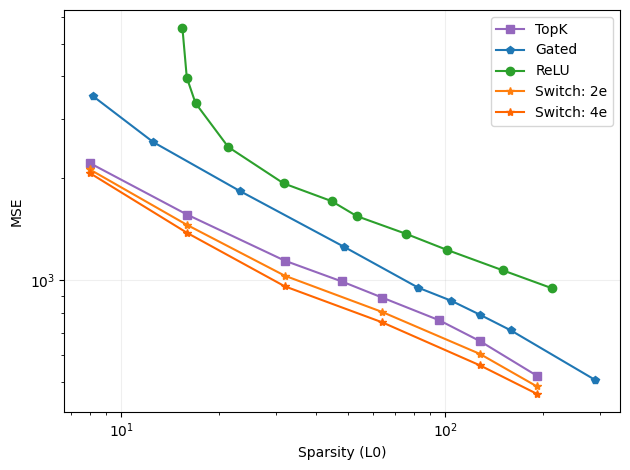

In [19]:
plt.plot(df_topk['l0'], df_topk['mse_loss'], label='TopK', marker='s', color='#9467bd')
plt.plot(df_gated['l0'], df_gated['mse_loss'], label='Gated', marker='p', color='#1f77b4')
plt.plot(df_relu['l0'], df_relu['mse_loss'], label='ReLU', marker='o', color='#2ca02c')

plt.plot(df_switch_flop2['l0'], df_switch_flop2['mse_loss'], label='Switch: 2e', marker='*', color='#ff7f0e')
plt.plot(df_switch_flop4['l0'], df_switch_flop4['mse_loss'], label='Switch: 4e', marker='*', color='#ff6600')
#plt.plot(df_switch_flop8['l0'], df_switch_flop8['mse_loss'], label='Switch: 8e', marker='*', color='#ff3300')

plt.xscale('log')
plt.yscale('log')

plt.xlabel("Sparsity (L0)")
plt.ylabel("MSE")

plt.legend()

plt.grid(True, which="major", ls="-", alpha=0.2)


plt.tight_layout()
plt.savefig("flopmatch_l0_mse.png")
plt.show()

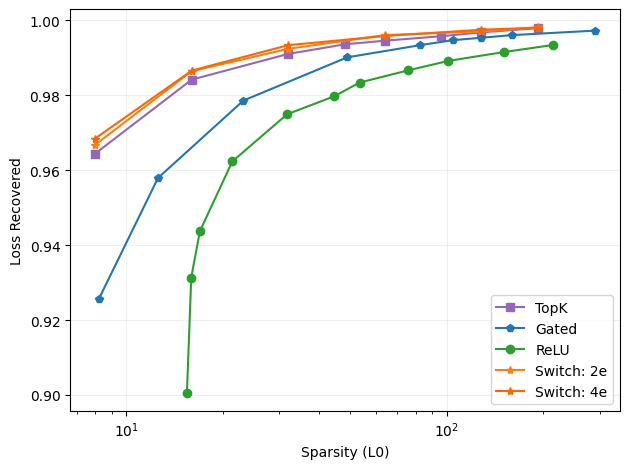

In [16]:
plt.plot(df_topk['l0'], df_topk['frac_recovered'], label='TopK', marker='s', color='#9467bd')
plt.plot(df_gated['l0'], df_gated['frac_recovered'], label='Gated', marker='p', color='#1f77b4')
plt.plot(df_relu['l0'], df_relu['frac_recovered'], label='ReLU', marker='o', color='#2ca02c')

plt.plot(df_switch_flop2['l0'], df_switch_flop2['frac_recovered'], label='Switch: 2e', marker='*', color='#ff7f0e')
plt.plot(df_switch_flop4['l0'], df_switch_flop4['frac_recovered'], label='Switch: 4e', marker='*', color='#ff6600')
#plt.plot(df_switch_flop8['l0'], df_switch_flop8['frac_recovered'], label='Switch: 8e', marker='*', color='#ff3300')

plt.xscale('log')
#plt.yscale('log')

plt.xlabel("Sparsity (L0)")
plt.ylabel("Loss Recovered")

plt.legend()

plt.grid(True, which="major", ls="-", alpha=0.2)


plt.tight_layout()
plt.savefig("flopmatch_l0_lossrec.png")
plt.show()

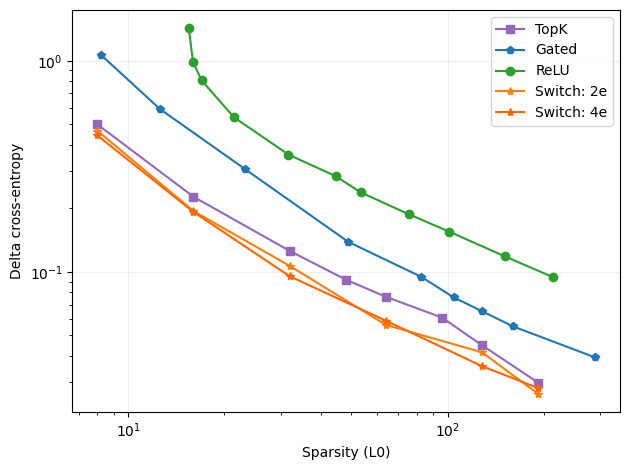

In [17]:
plt.plot(df_topk['l0'], df_topk['delta_ce'], label='TopK', marker='s', color='#9467bd')
plt.plot(df_gated['l0'], df_gated['delta_ce'], label='Gated', marker='p', color='#1f77b4')
plt.plot(df_relu['l0'], df_relu['delta_ce'], label='ReLU', marker='o', color='#2ca02c')

plt.plot(df_switch_flop2['l0'], df_switch_flop2['delta_ce'], label='Switch: 2e', marker='*', color='#ff7f0e')
plt.plot(df_switch_flop4['l0'], df_switch_flop4['delta_ce'], label='Switch: 4e', marker='*', color='#ff6600')
#plt.plot(df_switch_flop8['l0'], df_switch_flop8['delta_ce'], label='Switch: 8e', marker='*', color='#ff3300')


plt.xscale('log')
plt.yscale('log')

plt.xlabel("Sparsity (L0)")
plt.ylabel("Delta cross-entropy")

plt.legend()

plt.grid(True, which="major", ls="-", alpha=0.2)


plt.tight_layout()
plt.savefig("flopmatch_l0_deltace.png")
plt.show()

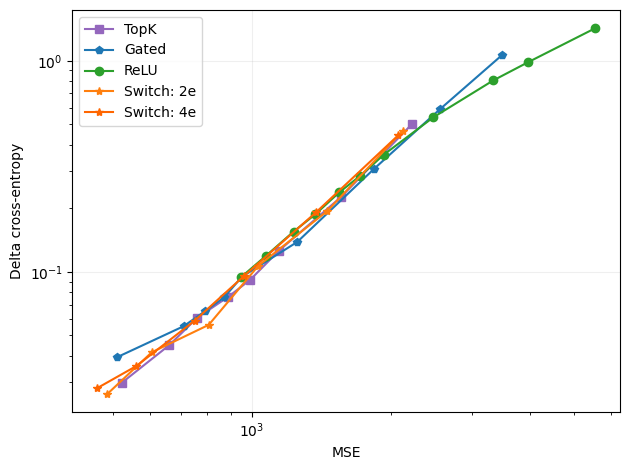

In [18]:
plt.plot(df_topk['mse_loss'], df_topk['delta_ce'], label='TopK', marker='s', color='#9467bd')
plt.plot(df_gated['mse_loss'], df_gated['delta_ce'], label='Gated', marker='p', color='#1f77b4')
plt.plot(df_relu['mse_loss'], df_relu['delta_ce'], label='ReLU', marker='o', color='#2ca02c')

plt.plot(df_switch_flop2['mse_loss'], df_switch_flop2['delta_ce'], label='Switch: 2e', marker='*', color='#ff7f0e')
plt.plot(df_switch_flop4['mse_loss'], df_switch_flop4['delta_ce'], label='Switch: 4e', marker='*', color='#ff6600')
#plt.plot(df_switch_flop8['mse_loss'], df_switch_flop8['delta_ce'], label='Switch: 8e', marker='*', color='#ff4d00')


plt.xscale('log')
plt.yscale('log')

plt.xlabel("MSE")
plt.ylabel("Delta cross-entropy")

plt.legend()

plt.grid(True, which="major", ls="-", alpha=0.2)


plt.tight_layout()
plt.savefig("flopmatch_mse_deltace.png")
plt.show()